In [45]:
import pandas as pd
import numpy as np

In [46]:
# preprocessing tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# New imports for detailed metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Load DataSet

In [47]:
df = pd.read_csv('kidney_disease.csv')
# Short look of data
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


# Feature Description

In [5]:
# age: "patient age (years)",
# bp : "blood pressure (mm/hg),
# sg : "urine specific gravity",
# al : "albumum in urine"
# hemo : hemoglobin level (g/dl)
# sc : serum creatinine(mg/dl)
# htn: Hypertension (yes/no)
# dm : diabetes mellitus (yes/no)
# cad: Coronary Artery Disease (yes/no)
# appet: Patient has a good or poor appetite
# pc: Pus Cell status (normal/abnormal)
# classification: The target column with two values: ckd (Chronic Kidney Disease) and not ckd

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

## Initial Data Cleaning

In [49]:
df.drop('id', axis=1, inplace=True)
df.columns = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
              'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
              'appet', 'pe', 'ane', 'classification']

df['dm'] = df['dm'].replace(to_replace={'\tno': 'no', '\tyes': 'yes', ' yes': 'yes'})
df['cad'] = df['cad'].replace(to_replace='\tno', value='no')
df['classification'] = df['classification'].replace(to_replace='ckd\t', value='ckd')


In [50]:
# Missing values of the dataset

df.isnull().sum()

age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

## Encoding and Type conversion

In [51]:
binary_map = {
    'rbc': {'normal': 1, 'abnormal': 0},
    'pc': {'normal': 1, 'abnormal': 0},
    'pcc': {'present': 1, 'notpresent': 0},
    'ba': {'present': 1, 'notpresent': 0},
    'htn': {'yes': 1, 'no': 0},
    'dm': {'yes': 1, 'no': 0},
    'cad': {'yes': 1, 'no': 0},
    'appet': {'good': 1, 'poor': 0},
    'pe': {'yes': 1, 'no': 0},
    'ane': {'yes': 1, 'no': 0},
    'classification': {'ckd': 1, 'notckd': 0}
}

for col, mapping in binary_map.items():
    df[col] = df[col].map(mapping)


In [52]:
numeric_cols = ['age', 'bp', 'bgr', 'bu', 'sc',
                'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    float64
 6   pc              335 non-null    float64
 7   pcc             396 non-null    float64
 8   ba              396 non-null    float64
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             329 non-null    float64
 16  wc              294 non-null    float64
 17  rc              269 non-null    flo

## Outlier Detection

In [54]:
numeric_cols = [
    'age', 'bp', 'bgr', 'bu', 'sc',
    'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc'
]


In [55]:
def detect_outliers_iqr(df, columns):
    outlier_info = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_info[col] = ((df[col] < lower) | (df[col] > upper)).sum()
    return pd.Series(outlier_info, name='Outlier_Count')

detect_outliers_iqr(df, numeric_cols)


age     10
bp      36
bgr     34
bu      38
sc      51
sod     16
pot      4
hemo     1
pcv      1
wc      10
rc       1
Name: Outlier_Count, dtype: int64

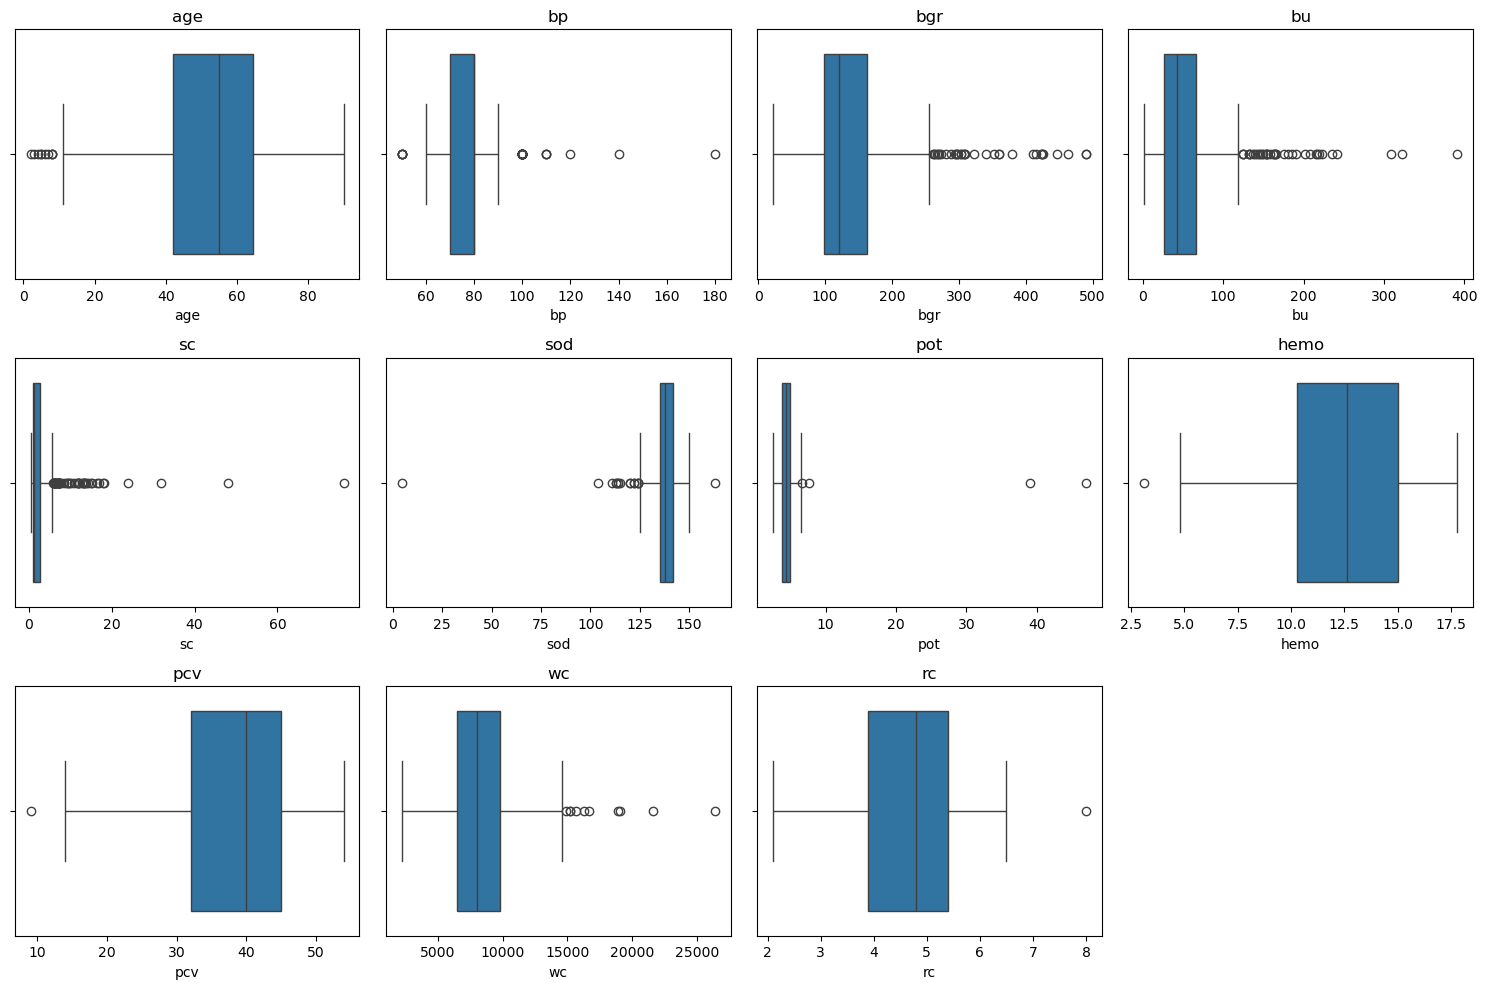

In [57]:
plt.figure(figsize=(15,10))

for i, col in enumerate(numeric_cols):
    plt.subplot(3,4,i+1)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


## Outlier Treatment Using Capping

In [58]:
def cap_outliers_iqr(df, columns):
    df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(
            df[col] < lower, lower,
            np.where(df[col] > upper, upper, df[col])
        )
    return df


In [59]:
df_lr = cap_outliers_iqr(df, numeric_cols)
df_rf = df.copy()   


In [60]:
df_rf.shape


(400, 25)

In [61]:
detect_outliers_iqr(df_lr, numeric_cols)


age     0
bp      0
bgr     0
bu      0
sc      0
sod     0
pot     0
hemo    0
pcv     0
wc      0
rc      0
Name: Outlier_Count, dtype: int64

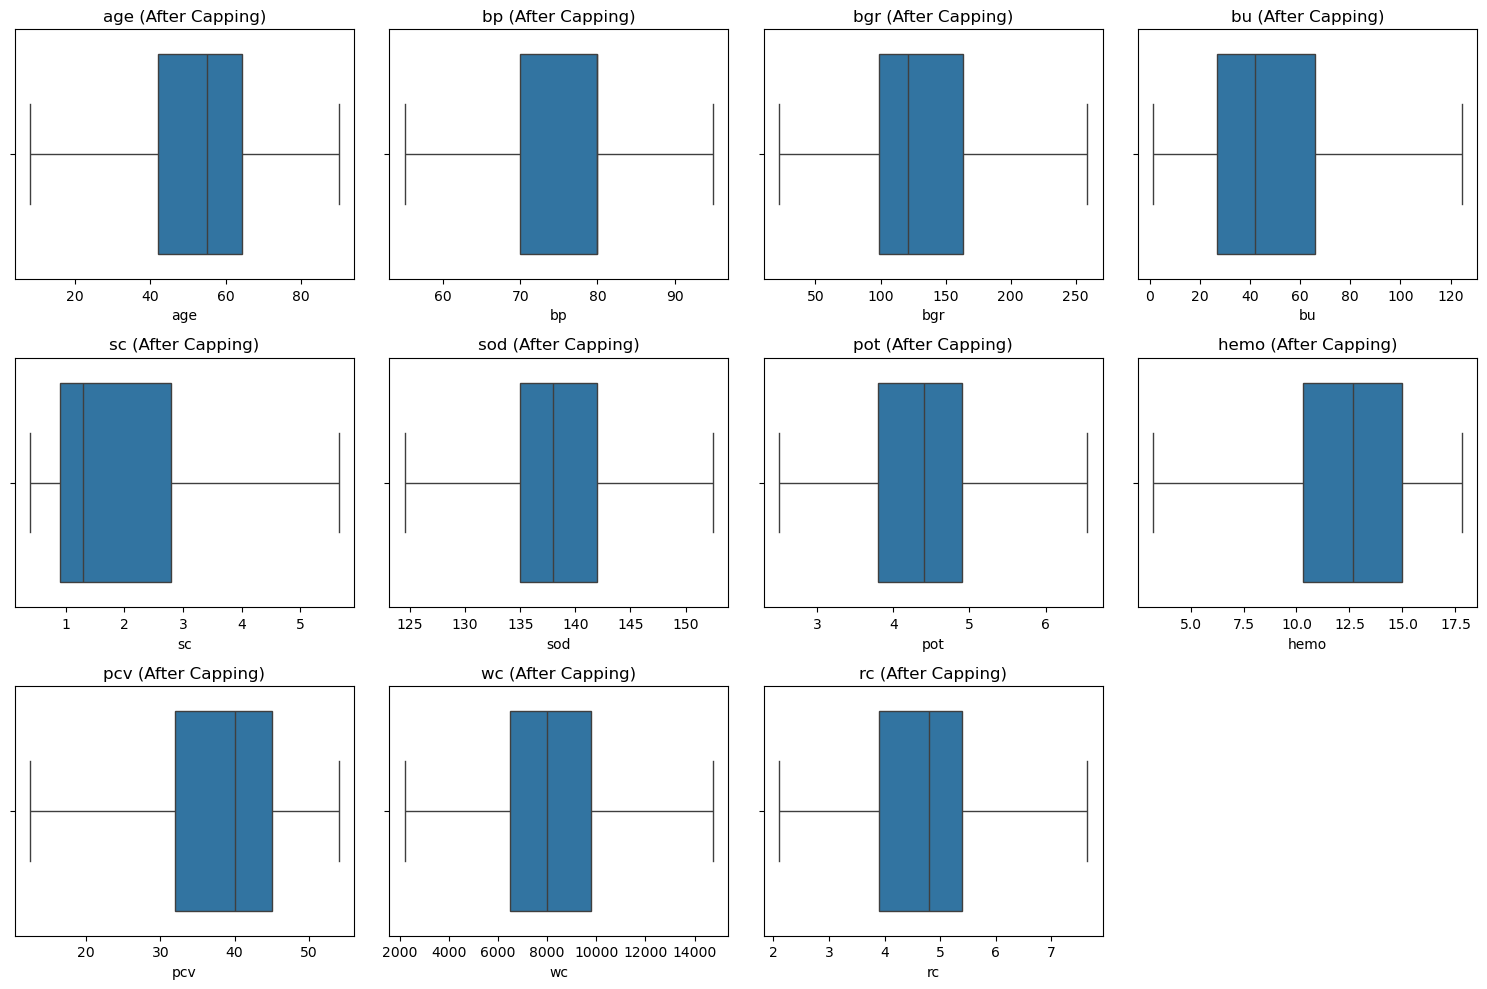

In [62]:
plt.figure(figsize=(15,10))

for i, col in enumerate(numeric_cols):
    plt.subplot(3,4,i+1)
    sns.boxplot(x=df_lr[col])
    plt.title(f'{col} (After Capping)')

plt.tight_layout()
plt.show()

## Exploratory Data Analysis

## Heatmap for checking correlation

In [49]:
corr = df.corr()

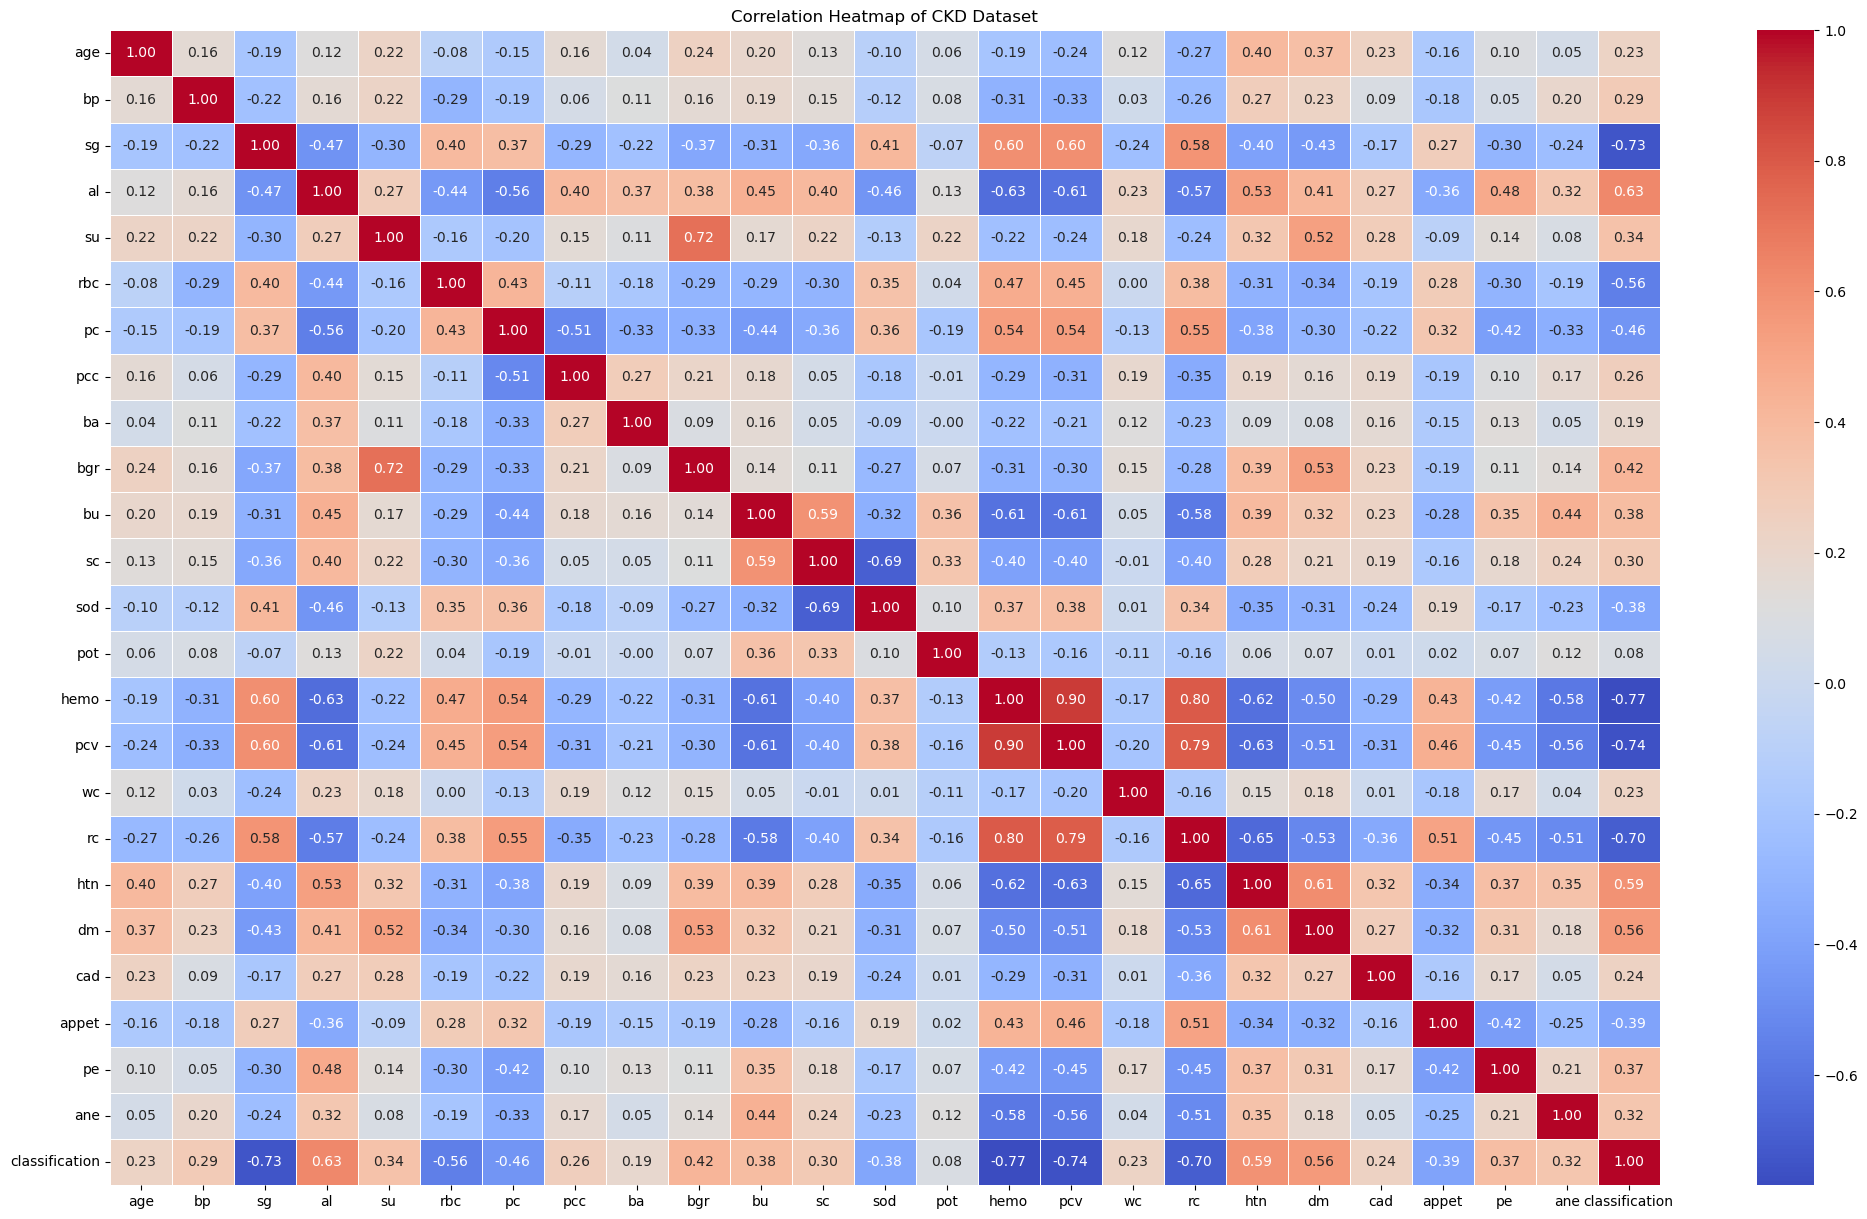

In [50]:
plt.figure(figsize=(25, 15))
sns.heatmap(
    corr,
    cmap="coolwarm",
    linewidths=0.5,
    cbar=True,
    annot=True,
    fmt=".2f"
)
plt.title("Correlation Heatmap of CKD Dataset")
plt.show()

## Identify highly correlated features

In [46]:
# Upper triangle matrix
upper_tri = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(bool)
)

# Threshold
threshold = 0.9

# Features to drop
to_drop = [
    col for col in upper_tri.columns
    if any(upper_tri[col] > threshold)
]

print("Highly correlated features:")
print(to_drop)

Highly correlated features:
[]


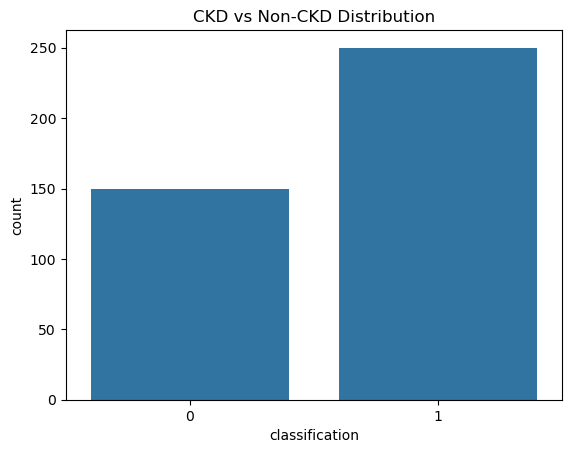

In [14]:
# Check for data imbalance.

sns.countplot(x=df['classification'])
plt.title('CKD vs Non-CKD Distribution')
plt.show()

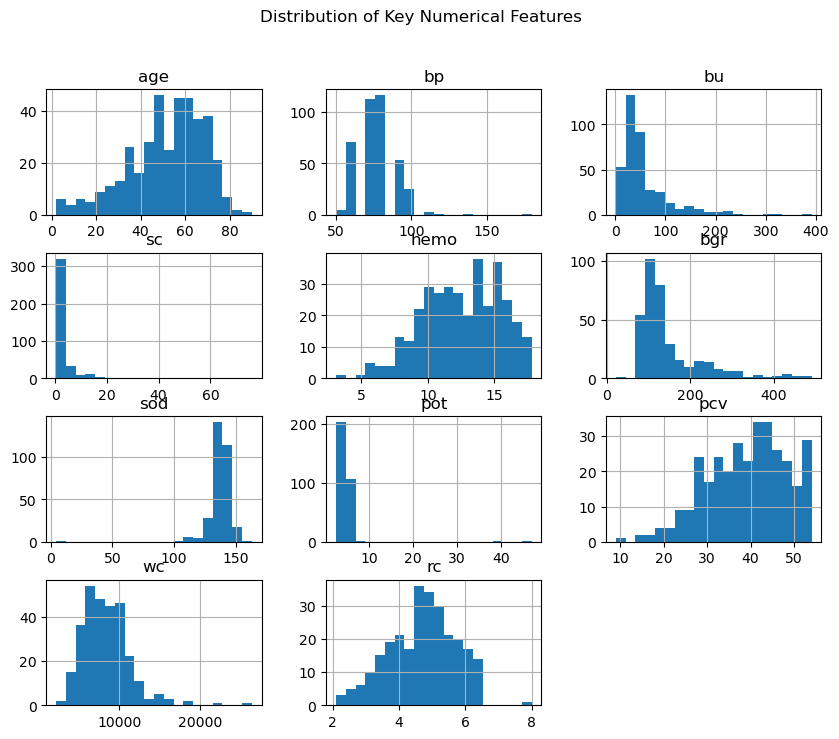

In [41]:
num_cols = ['age','bp','bu','sc','hemo','bgr','sod',
            'pot','pcv', 'wc', 'rc']

df[num_cols].hist(figsize=(10,8), bins=20)
plt.suptitle('Distribution of Key Numerical Features')
plt.show()

In [40]:
df[num_cols].skew()

age     -0.668259
bp       1.605429
bu       2.634374
sc       7.509538
hemo    -0.335095
bgr      2.010773
sod     -6.996569
pot     11.582956
pcv     -0.433679
wc       1.621589
rc      -0.183329
dtype: float64

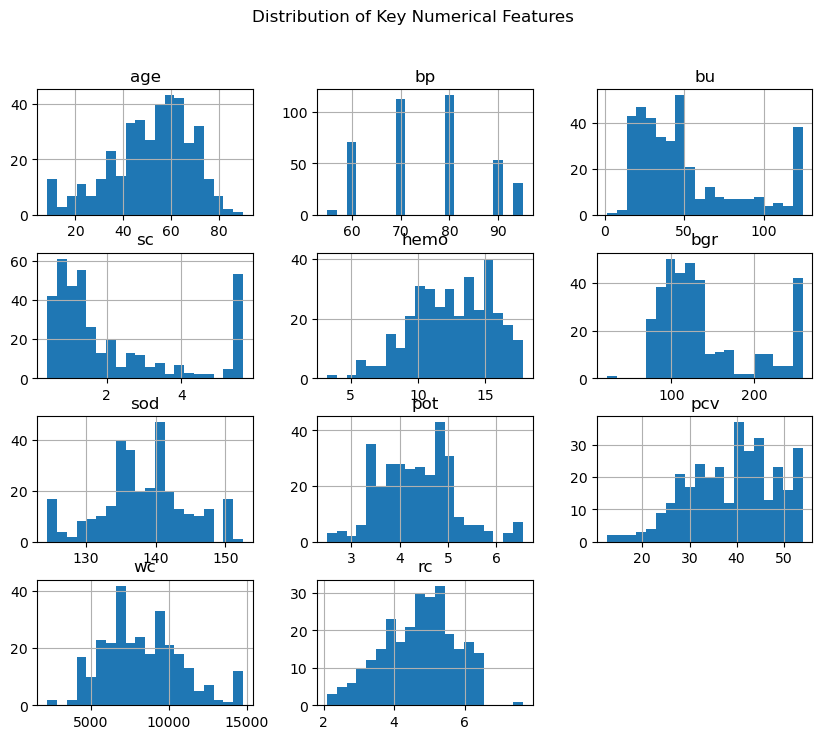

In [38]:
num_cols = ['age','bp','bu','sc','hemo','bgr','sod',
            'pot','pcv', 'wc', 'rc']

df_lr[num_cols].hist(figsize=(10,8), bins=20)
plt.suptitle('Distribution of Key Numerical Features')
plt.show()


In [39]:
df_lr[num_cols].skew()

age    -0.615760
bp      0.090421
bu      1.078868
sc      1.153813
hemo   -0.331398
bgr     1.022962
sod    -0.183473
pot     0.383004
pcv    -0.406615
wc      0.495374
rc     -0.217677
dtype: float64

## Train test split

In [110]:
X = df.drop('classification', axis=1)
y = df['classification']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Logistic Regression

## Applying the Pipeline 

In [140]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_cols = list(binary_map.keys())
categorical_cols.remove('classification')

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant'))
])



In [141]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)


In [142]:
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [143]:
pipe_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bp', 'bgr', 'bu',
                                                   'sc', 'sod', 'pot', 'hemo',
                                                   'pcv', 'wc', 'rc']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  ['rbc', 'pc', 'pcc', 'ba',
                                                   'htn', 'dm', 'cad', 'appet',
                                                   'pe', 'ane'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

## Applying GridSearchCV

In [144]:
param_grid_lr = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
    'classifier__C': [0.01, 0.1, 1, 10]
}


In [145]:
grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    cv=10,
    scoring='accuracy'
)

grid_lr.fit(X_train, y_train)



GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bp',
                                                                          'bgr',
                                                                          'bu',
                                                                          'sc',
                                                                          'sod',
                                                                          'pot',
                                                                          'hemo',
                                                                          'pcv',
                                                                          'wc',
                                                                          'rc']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='constant'))]),
                                                                         ['rbc',
                                                                          'pc',
                                                                          'pcc',
                                                                          'ba',
                                                                          'htn',
                                                                          'dm',
                                                                          'cad',
                                                                          'appet',
                                                                          'pe',
                                                                          'ane'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                  'constant'],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']},
             scoring='accuracy')

In [146]:
print("Best parameters:", grid_lr.best_params_)

y_pred_lr = grid_lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))


Best parameters: {'classifier__C': 10, 'preprocessor__cat__imputer__strategy': 'constant', 'preprocessor__num__imputer__strategy': 'median'}
Logistic Regression Accuracy: 0.9875


# Random Forest Classifier

## Applying Pipeline

In [147]:
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [148]:
param_grid_rf = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10]
}


## Applying GridSearchCV

In [149]:
grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    cv=10,
    scoring='accuracy'
)

grid_rf.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bp',
                                                                          'bgr',
                                                                          'bu',
                                                                          'sc',
                                                                          'sod',
                                                                          'pot',
                                                                          'hemo',
                                                                          'pcv',
                                                                          'wc',
                                                                          'rc']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='constant'))]),
                                                                         ['rbc',
                                                                          'pc',
                                                                          'pcc',
                                                                          'ba',
                                                                          'htn',
                                                                          'dm',
                                                                          'cad',
                                                                          'appet',
                                                                          'pe',
                                                                          'ane'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 5, 10],
                         'classifier__n_estimators': [100, 200],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']},
             scoring='accuracy')

In [150]:
print("Best parameters:", grid_rf.best_params_)

y_pred_rf = grid_rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200, 'preprocessor__num__imputer__strategy': 'median'}
Random Forest Accuracy: 1.0


In [151]:
from sklearn.model_selection import cross_val_score

cv_lr = cross_val_score(grid_lr.best_estimator_, X, y, cv=10)
cv_rf = cross_val_score(grid_rf.best_estimator_, X, y, cv=10)

print("LR CV mean:", cv_lr.mean())
print("RF CV mean:", cv_rf.mean())


LR CV mean: 0.9924999999999999
RF CV mean: 0.9925


## Evaluate and print the result

In [152]:
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [153]:
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9875

Confusion Matrix:
 [[27  1]
 [ 0 52]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.98      1.00      0.99        52

    accuracy                           0.99        80
   macro avg       0.99      0.98      0.99        80
weighted avg       0.99      0.99      0.99        80



## Cross Validation

In [154]:
cv_scores = cross_val_score(
    pipe_lr,          # pipeline (preprocessing + model)
    X_train,          # use ONLY training data
    y_train,
    cv=10,            # 10-fold CV
    scoring='accuracy'
)


print("Cross-validation scores:", cv_scores)
print(np.mean(cv_scores))
print("Mean CV accuracy:", cv_scores.mean())




Cross-validation scores: [0.96875 1.      1.      1.      1.      1.      1.      1.      0.96875
 0.9375 ]
0.9875
Mean CV accuracy: 0.9875
